In [1]:
import keras
import numpy as np
from neuralStellar import *
import pymc3 as pm
import theano.tensor as T
import corner

Using TensorFlow backend.


In [18]:
m1=NNmodel('evo',['mass','age','feh','MLT'],['L','Teff','delnu'])
m1.loadModel('Ran_files/small_grid_28/small_grid_model.h5')
#m1.loadModel('MGM_test.h5')
#m1.loadModel('SGM_lrtest.h5')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 128)               640       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512 

In [19]:
Msun=1
Agesun=4.5
Fehsun=0
MLTsun=1.9
print('L/Lsun', 'Teff', 'delta nu', '=')
print(10**m1.model.predict(np.array([[np.log10(Msun),np.log10(Agesun),Fehsun,MLTsun]])).T)
#1, 5777, 135

L/Lsun Teff delta nu =
[[1.0957384e+00]
 [5.9089731e+03]
 [1.3488092e+02]]


Inputs:
M=N(1,0.1)<br>
Age=N(4.5,0.5)<br>
feh=N(0,0.1)<br>
MLT=N(1.9,0.1)<br>
<br>
Outputs(obs):<br>
L=N(1,0.1)<br>
Teff=N(5777,70)<br>
delnu=N(135,15)<br>

In [69]:
m1.getWeights()
weights=m1.model.get_weights()

def manualPredict(inputs):
    #input shape = 1D array with length as number of NN inputs
    no_hidden_layers = len(weights)/2-1
    xx=inputs
    for i in np.arange(0,no_hidden_layers)*2:
        i=int(i)
        xx=T.nnet.relu(pm.math.dot(xx,weights[i])+weights[i+1])
    xx=pm.math.dot(xx,weights[-2])+weights[-1]
    return xx.T

model = pm.Model()
with model:
    BoundM = pm.Bound(pm.Lognormal,lower=0)
    M = BoundM('mass',np.log(1.2),0.5)
    BoundAge = pm.Bound(pm.Lognormal,lower=0)
    Age = BoundAge('age',np.log(4.5),1.0)
    #feh = pm.Normal('feh',0,0.5)
    #BoundMLT = pm.Bound(pm.Lognormal,lower=1.65, 2.35)
    #MLT = BoundMLT('MLT',1.9,0.3)
    
    obs = pm.Deterministic('obs',manualPredict([np.log10(M), np.log10(Age), 0, 1.9]))
    
    #obs data from small grid row 7992
    obs_L = pm.Normal('obs_L',10**obs[0],0.01, observed=1.10587977656106)
    obs_Teff = pm.Normal('obs_Teff',10**obs[1],70, observed=5915.32055829505)
    obs_delnu = pm.Normal('obs_delnu',10**obs[2],0.1, observed=134.4937686)

#start = {'mass': 0.8, 'age': 2.5, 'feh':0.1, 'MLT':1.8}
start = {'mass': 0.8, 'age': 2.5}
with model:
    trace = pm.sample(tune=5000, target_accept = 0.99, start=start)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [age, mass]
Sampling 2 chains: 100%|██████████████████████████████████████████████████████| 11000/11000 [05:38<00:00, 32.51draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


In [70]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mass,1.001327,0.003462,0.000227,0.994597,1.007565,157.736872,0.999301
age,4.501604,0.142140,0.009329,4.250846,4.782171,156.966759,0.999137
obs__0,0.043265,0.003696,0.000239,0.035992,0.050260,160.643362,0.999596
obs__1,3.771877,0.000679,0.000045,3.770620,3.773218,158.622571,0.999369
obs__2,2.128715,0.000313,0.000012,2.128143,2.129367,658.059834,1.001182


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002B27A54C278>,
      dtype=object)

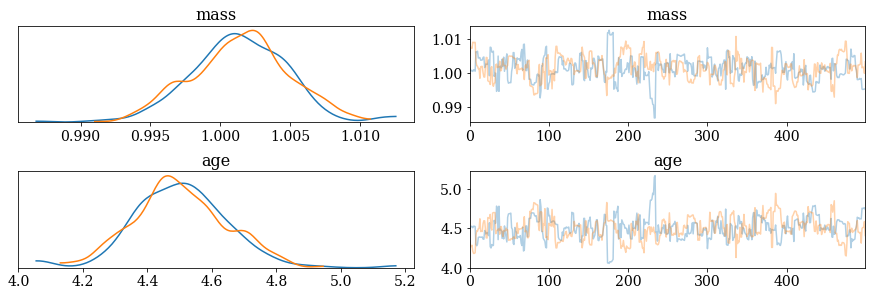

In [71]:
pm.plots.traceplot(trace,var_names=['mass','age'])

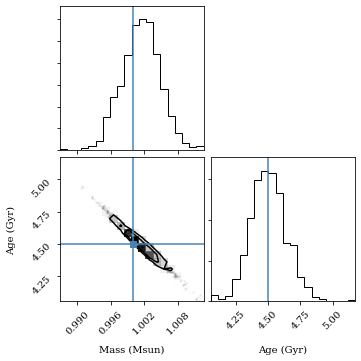

In [76]:
#corner.corner(np.array([trace['mass'], trace['age'], trace['feh'], trace['MLT']]).T, truths=[1.0, 4.5, 0, 1.9],
#             labels=['Mass', 'Age', 'Fe/H', 'Alpha_MLT']);
corner.corner(np.array([trace['mass'], trace['age']]).T, truths=[1.0,4.5], labels=['Mass (Msun)','Age (Gyr)']);

In [80]:
true_M=1
true_age = 4.577450829
print('error (dex) on mass = ',abs((np.mean(trace['mass'])-true_M)/true_M))
print('error (dex) on age = ',abs((np.mean(trace['age'])-true_age)/true_age))

error (dex) on mass =  0.0013274694638958362
error (dex) on age =  0.016569595239434357
